## import libraries

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from skimage import color, exposure
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

C:\Users\imach\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read Images

In [2]:
img_vehicle_GTI_Far = glob.glob("./vehicles/GTI_Far/*.png")
img_vehicle_GTI_Left = glob.glob("./vehicles/GTI_Left/*.png")
img_vehicle_GTI_MiddleClose = glob.glob("./vehicles/GTI_MiddleClose/*.png")
img_vehicle_GTI_Right = glob.glob("./vehicles/GTI_Right/*.png")
img_vehicle_GTI_KITTI = glob.glob("./vehicles/KITTI_extracted/*.png")

img_non_vehicle_extra = glob.glob("./non-vehicles/Extras/*.png")
img_non_vehicle_GTI = glob.glob("./non-vehicles/GTI/*.png")

print("GTI_Far", len(img_vehicle_GTI_Far))
print("GTI_Left", len(img_vehicle_GTI_Left))
print("GTI_MiddleClose", len(img_vehicle_GTI_MiddleClose))
print("GTI_Right", len(img_vehicle_GTI_Right))
print("GTI_KITTI", len(img_vehicle_GTI_KITTI))
print("GTI_non_Extra", len(img_non_vehicle_extra))
print("GTI_non_GTI", len(img_non_vehicle_GTI))

GTI_Far 834
GTI_Left 909
GTI_MiddleClose 419
GTI_Right 664
GTI_KITTI 5966
GTI_non_Extra 5068
GTI_non_GTI 3900


## Define Hyperparameters


In [28]:
#### HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

#### Spatial, Histogram parameters
spatial = 32
histbin = 32
color_space = 'HSV'

#### Channel used for HOG
hog_channel='ALL'

#### flag to define each features
is_spatial_feat=True
is_hist_feat=True
is_hog_feat=True

#### ROI 
ystart = 400
ystop = 656

#### Tracking
threshold = 2

In [4]:
img_vehicle = []
img_non_vehicle = []
img_vehicle.extend(img_vehicle_GTI_Far)
img_vehicle.extend(img_vehicle_GTI_Left)
img_vehicle.extend(img_vehicle_GTI_MiddleClose)
img_vehicle.extend(img_vehicle_GTI_Right)
img_vehicle.extend(img_vehicle_GTI_KITTI)
img_non_vehicle.extend(img_non_vehicle_extra)
img_non_vehicle.extend(img_non_vehicle_GTI)

print("Vehicle images", len(img_vehicle))
print("non-Vehicle images", len(img_non_vehicle))


Vehicle images 8792
non-Vehicle images 8968


## Function to Return Some Characteristics of the Dataset

In [5]:
def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    sample = mpimg.imread(car_list[0])
    data_dict["image_shape"] = (sample.shape[0], sample.shape[1], sample.shape[2])
    data_dict["data_type"] = sample.dtype
    return data_dict

In [6]:
data_info = data_look(img_vehicle, img_non_vehicle)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


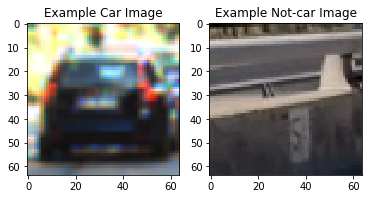

In [7]:
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(img_vehicle))
notcar_ind = np.random.randint(0, len(img_non_vehicle))
# Read in car / not-car images
car_image = mpimg.imread(img_vehicle[car_ind])
notcar_image = mpimg.imread(img_non_vehicle[notcar_ind])
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title("Example Car Image")
plt.subplot(122)
plt.imshow(notcar_image)
plt.title("Example Not-car Image")


## Scikit-image HOG


In [8]:
def get_hog_features(img, pix_per_cell=8, cell_per_block=2, orient=9, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block),
                                 visualise=True, feature_vector=feature_vec,
                                 block_norm="L2-Hys")
        return features, hog_image
    else:
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                      cells_per_block=(cell_per_block, cell_per_block),
                      visualise=False,feature_vector=feature_vec,
                      block_norm="L2-Hys")
        return features

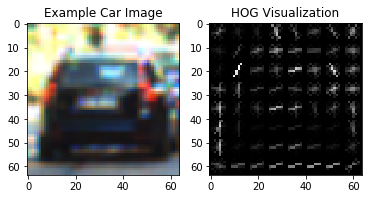

In [9]:
# Generate a random index to look at HOG features
ind = np.random.randint(0, len(img_vehicle))
# Read in the image
gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)

# Call our function with vis = True to see an image output
features, hog_image = get_hog_features(gray,
                                       pix_per_cell = pix_per_cell,
                                       cell_per_block = cell_per_block,
                                       orient = orient,
                                       vis = True,
                                       feature_vec = False)


# Plot the exmples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title("Example Car Image")
plt.subplot(122)
plt.imshow(hog_image, cmap="gray")
plt.title("HOG Visualization")

## Color Feature Extraction


In [10]:
# Define at function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to copute color histgram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histgram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [11]:
# Generate a random index to look at HOG features
ind = np.random.randint(0, len(img_vehicle))
# Read in the image
image = mpimg.imread(img_vehicle[ind])
spatial_feature = bin_spatial(image, size=(spatial, spatial))
color_hist_feature = color_hist(image, nbins = histbin)


In [12]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32,
                        hist_range=(0,256), orient=9, pix_per_cell=8, cell_per_block=2, 
                        hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Define an empty list tto receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space == 'RGB':
        feature_image = np.copy(img)
    elif color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    else:
        print("color_space", color_space, "not supported")
        feature_image = np.copy(img)
    # Compute spatial features if flag is set
    if spatial_feat  == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # append features to list
        img_features.extend(spatial_features)
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # append features to list
        img_features.extend(hist_features)
    # Compute HOG fefatures if flag is set
    if hog_feat == True:
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_feature = get_hog_features(feature_image[:,:,channel], orient=orient,
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                    vis=False, feature_vec=True)
                hog_features.extend(hog_feature)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient=orient,
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                vis=False, feature_vec=True)
        # Append features to list
        img_features.extend(hog_features)
    # Return concatenated array of features
    return img_features

## extract features for all images

In [13]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB',spatial_size=(32,32), hist_bins=32,
                     hist_range = (0,256), orient=9, pix_per_cell=8, cell_per_block=2,
                     hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for path in imgs:
        # Read in each one by one
        img = mpimg.imread(path)
        feature = single_img_features(img, color_space=cspace, spatial_size=spatial_size, 
                            hist_bins=hist_bins, hist_range=hist_range,
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, 
                            hog_feat=hog_feat)
        features.append(feature)
        
    # Return list of feature vectors
    return features


In [14]:

car_features = extract_features(img_vehicle, cspace=color_space, spatial_size=(spatial,spatial),
                               hist_bins=histbin, hist_range=(0, 256), orient=orient,
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               hog_channel=hog_channel, spatial_feat=is_spatial_feat, 
                               hist_feat=is_hist_feat, hog_feat=is_hog_feat)
notcar_features = extract_features(img_non_vehicle, cspace=color_space, spatial_size=(spatial,spatial),
                               hist_bins=histbin, hist_range=(0, 256), orient=orient,
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                               hog_channel=hog_channel, spatial_feat=is_spatial_feat, 
                               hist_feat=is_hist_feat, hog_feat=is_hog_feat)


8460


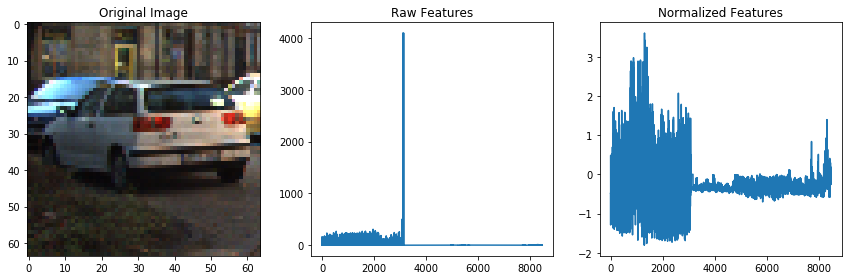

In [15]:
print(len(car_features[0]))
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-colun scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(img_vehicle))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(img_vehicle[car_ind]))
    plt.title("Original Image")
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title("Raw Features")
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title("Normalized Features")
    fig.tight_layout()
else:
    print("Your function only returns empty featur vectors ...")

## Data Split


In [16]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(img_vehicle)), np.zeros(len(img_non_vehicle))))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

## Learn Dataset

In [17]:
print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))

# Use a Linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), "Seconds to train SVC ...")
# Check the score of the SVC
print('test accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print("My SVC predicts: ", svc.predict(X_test[0:n_predict]))
print("For these", n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict, 'labels with SVC')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 8460
49.43 Seconds to train SVC ...
test accuracy of SVC =  0.9828
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  0.  1.  1.  0.]
0.01504 Seconds to predict 10 labels with SVC


## Sliding Windows

In [18]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes rawn
    return imcopy

# Define a function that takes an image, start and stop positions in both x and y,
# window size (x and y dimensions), and overlap function (for both x and y)
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None),
                xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start = 0
    if x_start_stop[1] == None:
        x_stop = img.shape[1]
    if y_start_stop[0] == None:
        y_start = 0
    if y_start_stop[1] == None:
        y_stop = img.shape[0]
    # Commpute the span of the region to be searched
    spanX = x_stop - x_start
    spanY = y_stop - y_start
    # Compute the number of pixels per step in x/y
    spanX = x_stop - x_start
    spanY = y_stop - y_start
    # Compute the number of pixels per step in x/y
    stepX = int(xy_window[0]*(1-xy_overlap[0]))
    stepY = int(xy_window[1]*(1-xy_overlap[1]))
    # Compute the number of windows in x/y
    numWindowsX = spanX // stepX - 1
    numWindowsY = spanY // stepY - 1
    # Initialize a lisst to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for i in range(numWindowsY):
        for j in range(numWindowsX):
            # Calculate each window position
            # Append window position to list
            x_begin = x_start + j*stepX
            x_end = x_begin + xy_window[0]
            y_begin = y_start + i*stepY
            y_end = y_begin + xy_window[1]
            window_position((x_begin, y_begin), (x_end, y_end))
            window_list.append(window_position)
    # Return the list of windows
    return window_list



## Define search windows

In [19]:
ystart = 400
ystop = 656
scale = 1.5

#### flag to define each features
param = {
    "color_space": color_space,
    "ystart": ystart,
    "ystop": ystop,
    "scale": scale,
    "svc": svc,
    "X_scaler": X_scaler,
    "orient": orient,
    "pix_per_cell": pix_per_cell,
    "cell_per_block": cell_per_block,
    "spatial_size": spatial,
    "hist_bins": histbin,
    "is_spatial_feat": is_spatial_feat,
    "is_hist_feat": is_hist_feat,
    "is_hog_feat": is_hog_feat
}

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, param):

    color_space = param["color_space"]
    ystart = param["ystart"]
    ystop = param["ystop"]
    scale = param["scale"]
    svc = param["svc"]
    X_scaler = param["X_scaler"]
    orient = param["orient"]
    pix_per_cell = param["pix_per_cell"]
    cell_per_block = param["cell_per_block"]
    spatial_size = param["spatial_size"]
    hist_bins = param["hist_bins"]
    is_spatial_feat  = param["is_spatial_feat"]
    is_hist_feat  = param["is_hist_feat"]
    is_hog_feat  = param["is_hog_feat"]
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    # ROI image is created
    img_tosearch = img[ystart:ystop,:,:]
    # color_space
    if color_space == 'RGB':
        ctrans_tosearch = np.copy(img_tosearch)
    elif color_space == 'HSV':
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
    elif color_space == 'HLS':
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
    elif color_space == 'YUV':
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
    elif color_space == 'YCrCb':
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
    else:
        print("color_space", color_space, "not supported")
        ctrans_tosearch = np.copy(img_tosearch)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block, feature_vec=False)

    # Return boxes
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            features = []
            spatial_features = []
            hist_feawtures = []
            hog_features = []
            
            if is_hog_feat == True:
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features.extend(hog_feat1)
                hog_features.extend(hog_feat2)
                hog_features.extend(hog_feat3)
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            if is_spatial_feat == True:
                spatial_features = bin_spatial(subimg, size=(spatial_size, spatial_size))
            if is_hist_feat == True:
                hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            features = np.hstack((spatial_features, hist_features, hog_features))
            
            test_features = X_scaler.transform((features).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale) + ystart
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw),(xbox_left+window, ytop_draw+window)))
            
    return bboxes



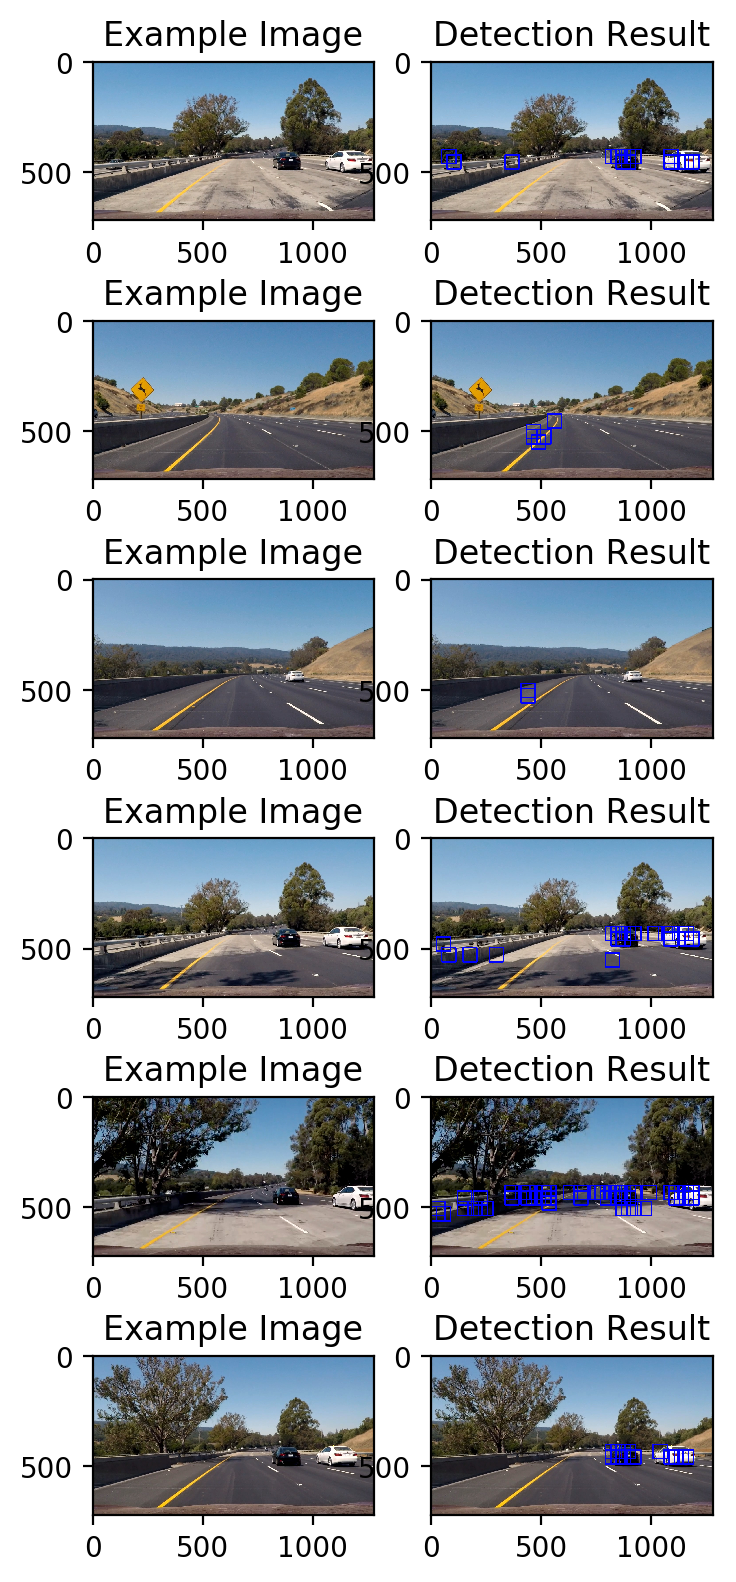

In [20]:
# Plot the examples
img1 = mpimg.imread("test_images/test1.jpg")
bboxes1 = find_cars(img1, param)
out_img1 = draw_boxes(img1, bboxes1, color=(0, 0, 255), thick=6)
img2 = mpimg.imread("test_images/test2.jpg")
bboxes2 = find_cars(img2, param)
out_img2 = draw_boxes(img2, bboxes2, color=(0, 0, 255), thick=6)
img3 = mpimg.imread("test_images/test3.jpg")
bboxes3 = find_cars(img3, param)
out_img3 = draw_boxes(img3, bboxes3, color=(0, 0, 255), thick=6)
img4 = mpimg.imread("test_images/test4.jpg")
bboxes4 = find_cars(img4, param)
out_img4 = draw_boxes(img4, bboxes4, color=(0, 0, 255), thick=6)
img5 = mpimg.imread("test_images/test5.jpg")
bboxes5 = find_cars(img5, param)
out_img5 = draw_boxes(img5, bboxes5, color=(0, 0, 255), thick=6)
img6 = mpimg.imread("test_images/test6.jpg")
bboxes6 = find_cars(img6, param)
out_img6 = draw_boxes(img6, bboxes6, color=(0, 0, 255), thick=6)


fig = plt.figure(figsize=(4,10),dpi=200)
#fig = plt.figure()
plt.subplot2grid((6, 2), (0, 0))
plt.imshow(img1)
plt.title("Example Image")
plt.subplot2grid((6, 2), (0, 1))
plt.imshow(out_img1)
plt.title("Detection Result")

plt.subplot2grid((6, 2), (1, 0))
plt.imshow(img2)
plt.title("Example Image")
plt.subplot2grid((6, 2), (1, 1))
plt.imshow(out_img2)
plt.title("Detection Result")

plt.subplot2grid((6, 2), (2, 0))
plt.imshow(img3)
plt.title("Example Image")
plt.subplot2grid((6, 2), (2, 1))
plt.imshow(out_img3)
plt.title("Detection Result")

plt.subplot2grid((6, 2), (3, 0))
plt.imshow(img4)
plt.title("Example Image")
plt.subplot2grid((6, 2), (3, 1))
plt.imshow(out_img4)
plt.title("Detection Result")

plt.subplot2grid((6, 2), (4, 0))
plt.imshow(img5)
plt.title("Example Image")
plt.subplot2grid((6, 2), (4, 1))
plt.imshow(out_img5)
plt.title("Detection Result")

plt.subplot2grid((6, 2), (5, 0))
plt.imshow(img6)
plt.title("Example Image")
plt.subplot2grid((6, 2), (5, 1))
plt.imshow(out_img6)
plt.title("Detection Result")


## Heatmaps for Multiple Detection / False Positives

In [21]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return threshold map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img




In [22]:
def create_heatmap(img, bboxes, threshold = 1):    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    return heatmap

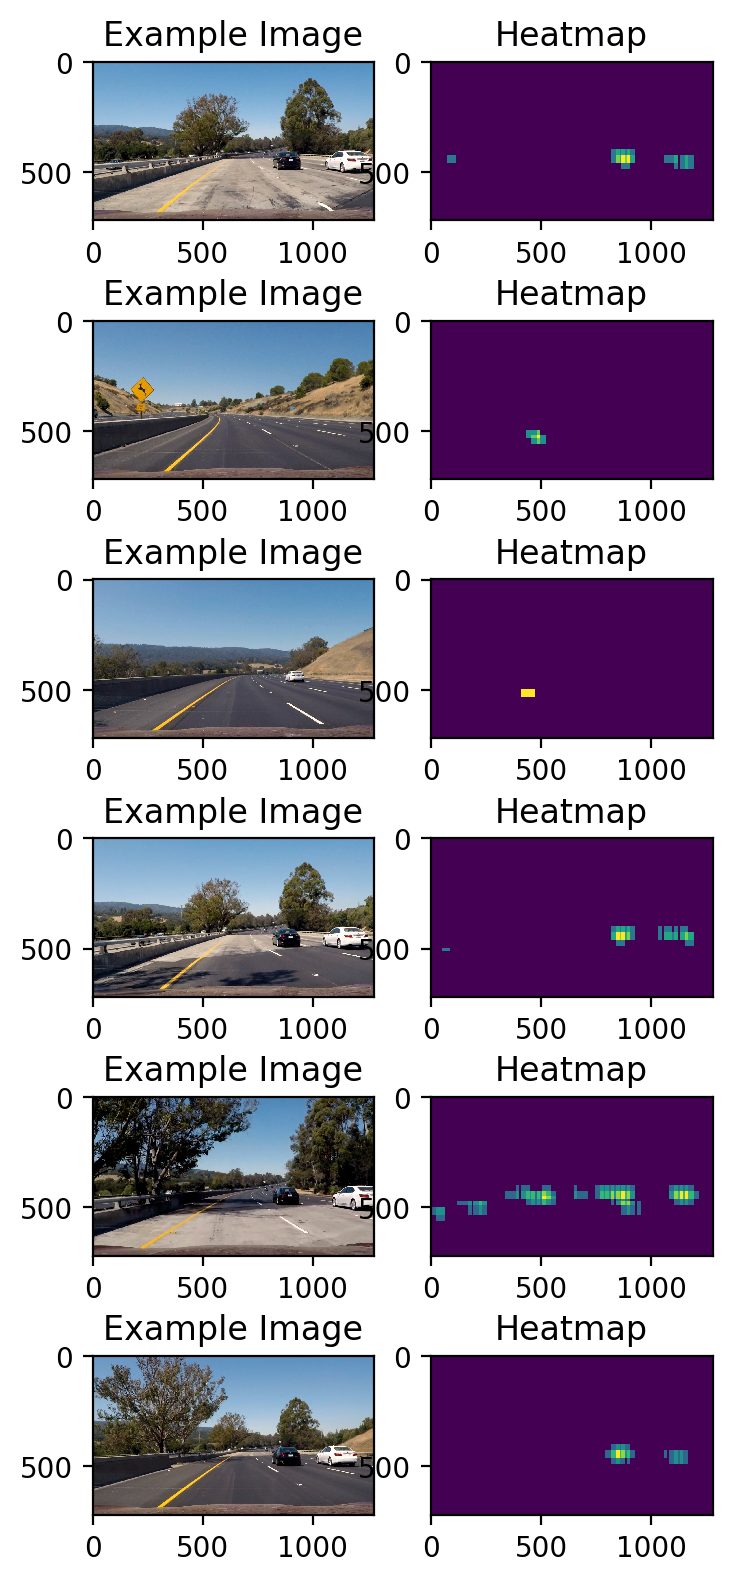

In [23]:
img1 = mpimg.imread("test_images/test1.jpg")
bboxes1 = find_cars(img1, param)
out_img1 = create_heatmap(img1, bboxes1, 1)
img2 = mpimg.imread("test_images/test2.jpg")
bboxes2 = find_cars(img2, param)
out_img2 = create_heatmap(img2, bboxes2, 1)
img3 = mpimg.imread("test_images/test3.jpg")
bboxes3 = find_cars(img3, param)
out_img3 = create_heatmap(img3, bboxes3, 1)
img4 = mpimg.imread("test_images/test4.jpg")
bboxes4 = find_cars(img4, param)
out_img4 = create_heatmap(img4, bboxes4, 1)
img5 = mpimg.imread("test_images/test5.jpg")
bboxes5 = find_cars(img5, param)
out_img5 = create_heatmap(img5, bboxes5, 1)
img6 = mpimg.imread("test_images/test6.jpg")
bboxes6 = find_cars(img6, param)
out_img6 = create_heatmap(img6, bboxes6, 1)
 

# Plot the examples
fig = plt.figure(figsize=(4,10),dpi=200)
#fig = plt.figure()
plt.subplot2grid((6, 2), (0, 0))
plt.imshow(img1)
plt.title("Example Image")
plt.subplot2grid((6, 2), (0, 1))
plt.imshow(out_img1)
plt.title("Heatmap")

plt.subplot2grid((6, 2), (1, 0))
plt.imshow(img2)
plt.title("Example Image")
plt.subplot2grid((6, 2), (1, 1))
plt.imshow(out_img2)
plt.title("Heatmap")

plt.subplot2grid((6, 2), (2, 0))
plt.imshow(img3)
plt.title("Example Image")
plt.subplot2grid((6, 2), (2, 1))
plt.imshow(out_img3)
plt.title("Heatmap")

plt.subplot2grid((6, 2), (3, 0))
plt.imshow(img4)
plt.title("Example Image")
plt.subplot2grid((6, 2), (3, 1))
plt.imshow(out_img4)
plt.title("Heatmap")

plt.subplot2grid((6, 2), (4, 0))
plt.imshow(img5)
plt.title("Example Image")
plt.subplot2grid((6, 2), (4, 1))
plt.imshow(out_img5)
plt.title("Heatmap")

plt.subplot2grid((6, 2), (5, 0))
plt.imshow(img6)
plt.title("Example Image")
plt.subplot2grid((6, 2), (5, 1))
plt.imshow(out_img6)
plt.title("Heatmap")


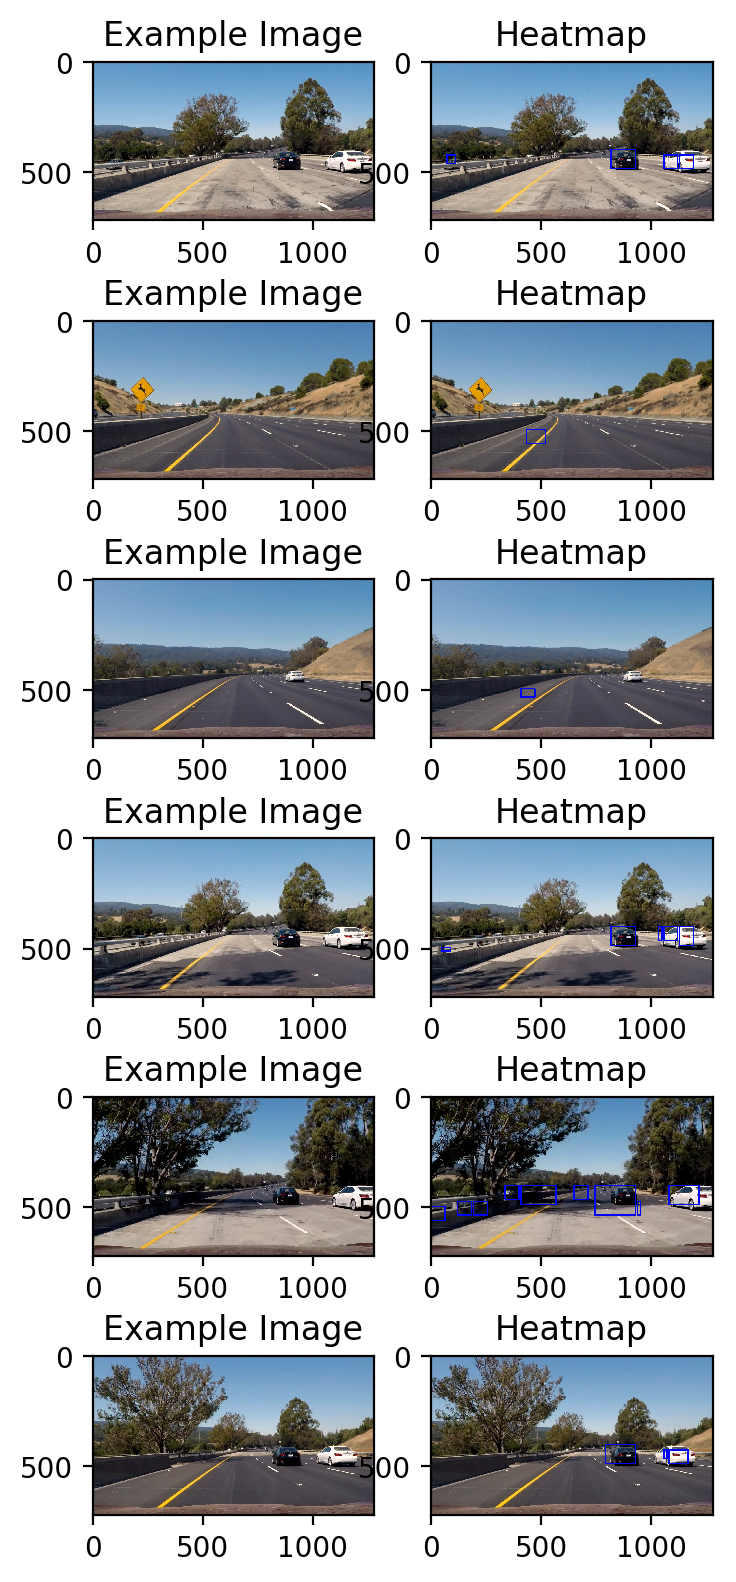

In [24]:
# Find final boxes from heatmap using label function
labels = label(out_img1)
draw_img1 = draw_labeled_bboxes(np.copy(img1), labels)
labels = label(out_img2)
draw_img2 = draw_labeled_bboxes(np.copy(img2), labels)
labels = label(out_img3)
draw_img3 = draw_labeled_bboxes(np.copy(img3), labels)
labels = label(out_img4)
draw_img4 = draw_labeled_bboxes(np.copy(img4), labels)
labels = label(out_img5)
draw_img5 = draw_labeled_bboxes(np.copy(img5), labels)
labels = label(out_img6)
draw_img6 = draw_labeled_bboxes(np.copy(img6), labels)


# Plot the examples
fig = plt.figure(figsize=(4,10),dpi=200)
#fig = plt.figure()
plt.subplot2grid((6, 2), (0, 0))
plt.imshow(img1)
plt.title("Example Image")
plt.subplot2grid((6, 2), (0, 1))
plt.imshow(draw_img1)
plt.title("Heatmap")

plt.subplot2grid((6, 2), (1, 0))
plt.imshow(img2)
plt.title("Example Image")
plt.subplot2grid((6, 2), (1, 1))
plt.imshow(draw_img2)
plt.title("Heatmap")

plt.subplot2grid((6, 2), (2, 0))
plt.imshow(img3)
plt.title("Example Image")
plt.subplot2grid((6, 2), (2, 1))
plt.imshow(draw_img3)
plt.title("Heatmap")

plt.subplot2grid((6, 2), (3, 0))
plt.imshow(img4)
plt.title("Example Image")
plt.subplot2grid((6, 2), (3, 1))
plt.imshow(draw_img4)
plt.title("Heatmap")

plt.subplot2grid((6, 2), (4, 0))
plt.imshow(img5)
plt.title("Example Image")
plt.subplot2grid((6, 2), (4, 1))
plt.imshow(draw_img5)
plt.title("Heatmap")

plt.subplot2grid((6, 2), (5, 0))
plt.imshow(img6)
plt.title("Example Image")
plt.subplot2grid((6, 2), (5, 1))
plt.imshow(draw_img6)
plt.title("Heatmap")

In [36]:
class HeatMap():
    def __init__(self, img, threshold):        
        self.heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        self.draw_img = np.zeros_like(img[:,:,0]).astype(np.float)
        self.threshold = threshold
    def update(self, img, bboxes):
        # Add heat to each box in box list        
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        self.heatmap = add_heat(heat, bboxes)
        # Apply threshold to help remove false positives
        self.heatmap = apply_threshold(self.heatmap, self.threshold)
        # Visualize the heatmap when displaying
        self.heatmap = np.clip(self.heatmap, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(self.heatmap)
        self.draw_img = draw_labeled_bboxes(img, labels)
    def get_heatmap(self):
        return self.heatmap
    def get_draw_img(self):
        return self.draw_img

In [37]:
def process_image(img, param, heatmap):
    bboxes = find_cars(img, param)
    heatmap.update(img, bboxes)
    #out_img = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    out_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return out_img
    

## Feed into Movie File

In [38]:
white_output = '.\\test_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(".\\test_video.mp4")

heatmap = HeatMap(image, threshold)
def my_process_image(clip, param, heatmap):
    def new_process_image(image):
        return process_image(image, param, heatmap)
    return clip.fl_image(new_process_image)

white_clip = clip1.fx(my_process_image, param, heatmap)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video .\test_output.mp4
[MoviePy] Writing video .\test_output.mp4


 97%|████████████████████████████████████████████████████████████████████████  | 38/39 [00:31<00:00,  1.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: .\test_output.mp4 

Wall time: 32.8 s


In [40]:
white_output = '.\\output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip(".\\project_video.mp4")

def my_process_image(clip, param, heatmap):
    def new_process_image(image):
        return process_image(image, param, heatmap)
    return clip.fl_image(new_process_image)

white_clip = clip2.fx(my_process_image, param, heatmap)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video .\output.mp4
[MoviePy] Writing video .\output.mp4


100%|█████████████████████████████████████████████████████████████████████▉| 1260/1261 [15:28<00:00,  1.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: .\output.mp4 

Wall time: 15min 28s
